# CREANDO UNA API ⚡



In [ ]:
# Cargamos los módulos que vamos a usar 
!pip install requests
import requests
import pandas as pd
from pandas.core.window import Rolling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
from urllib.request import urlopen
import json

# Importamos Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
token = 'afa678d99eae97dabe2de9f5f5134f0de39138b51184b6a623edcc43337bc675'

In [ ]:
def descarga_bmx_serie(serie,fechainicio,fechafin,token):
  url = 'https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/'+fechainicio+'/'+fechafin
  headers = {'Bmx-Token': token}
  response = requests.get(url,headers=headers)
  status = response.status_code
  if status !=200:
    return print('Error en la consulta, codigo {}'.format(status))
  raw_data = response.json()
  data = raw_data['bmx']['series'][0]['datos']
  df = pd.DataFrame(data)
  df.head()
  return df

In [ ]:
  dolares_bmx = descarga_bmx_serie('SF63528', '2017-01-01','2022-10-01', token)
  tiie28_bmx = descarga_bmx_serie('SF43783', '2017-01-01','2022-10-01', token)
  RI_bmx = descarga_bmx_serie('SF43707', '2017-01-01','2022-01-01', token)
  Costo_petroleo_bmx = descarga_bmx_serie('SI744', '2017-01-01','2022-01-01', token)
  PIB_as_construccion_bmx = descarga_bmx_serie('SR16581', '2017-01-01','2022-01-01', token)
  PIB_as_manufactura_alimentacion_bmx= descarga_bmx_serie('SR16583', '2017-01-01','2022-01-01', token)
  
  
  
  

In [ ]:
T_bmx

,fecha,dato
0,01/01/2017,"669,975.8"
1,01/04/2017,"649,722.4"
2,01/07/2017,"634,429.1"
3,01/10/2017,"670,693.0"
4,01/01/2018,"682,792.5"
5,01/04/2018,"680,851.6"
6,01/07/2018,"655,732.8"
7,01/10/2018,"681,283.5"
8,01/01/2019,"697,909.4"
9,01/04/2019,"690,844.4"


In [ ]:
dolares_bmx=dolares_bmx.rename(columns={'dato':'dolares'})
dolares_bmx['fecha'] = pd.to_datetime(dolares_bmx['fecha'])
scaler = MinMaxScaler()
df_transformed = scaler.fit_transform(dolares_bmx.iloc[:, 1:])
df_1 = pd.DataFrame(df_transformed)
df_1.insert(loc = 0, column = 'Date', value = dolares_bmx["fecha"]) 
df_1.columns = dolares_bmx.columns
df_1=df_1.set_index('fecha')
df_1['dolares']=df_1['dolares'].astype(float)
df_1=df_1.resample('Q').mean()

In [ ]:
tiie28_bmx=tiie28_bmx.rename(columns={'dato':'tiie28'})
tiie28_bmx['fecha'] = pd.to_datetime(tiie28_bmx['fecha'])
scaler = MinMaxScaler()
df_transformed2 = scaler.fit_transform(tiie28_bmx.iloc[:, 1:])
df_2 = pd.DataFrame(df_transformed2)
df_2.insert(loc = 0, column = 'Date', value = tiie28_bmx["fecha"]) 
df_2.columns = tiie28_bmx.columns
df_2=df_2.set_index('fecha')
df_2['tiie28']=df_2['tiie28'].astype(float)
df_2=df_2.resample('Q').mean()


In [ ]:
df_outer=df_1.join(df_2, how="outer")
df_outer

,dolares,tiie28
fecha,,
2017-03-31,0.300036,0.496406
2017-06-30,0.146671,0.590003
2017-09-30,0.096591,0.623198
2017-12-31,0.202203,0.631484
2018-03-31,0.168944,0.750365
2018-06-30,0.259088,0.770328
2018-09-30,0.201350,0.794463
2018-12-31,0.280461,0.819115
2019-03-31,0.229980,0.884785


# Analisis Exploratorio de Datos (EDA)

In [ ]:
df_outer.describe().round()

,dolares,tiie28
count,24.0,24.0
mean,0.0,1.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,1.0
75%,0.0,1.0
max,1.0,1.0


In [ ]:
import plotly.express as px

fig = px.line(df_outer,y=df_outer.columns, facet_col_wrap=2, title="Variables Macroeconómicas")
fig.update_yaxes(matches=None)
fig.show()

In [ ]:
fig = px.area(df_outer, y=df_outer.columns, facet_col_wrap=1, title= "Variables macroeconómicas")
fig.update_yaxes(matches=None)
fig.show()

##Correlación

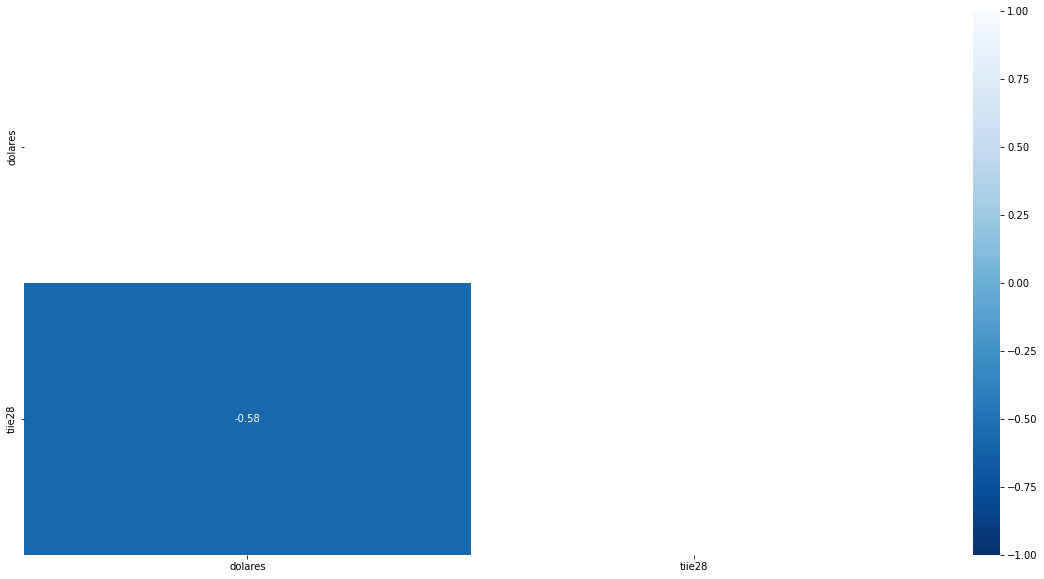

In [ ]:
##Resulta más intuitivo ver la matriz de correlación a través de un gráfico-heatmap de seaborn
plt.figure(figsize=(20,10)) #Definimos el tamaño del gráfico

#Definimos la correlación
upp_mat = np.triu(df_outer.corr())
sns.heatmap(df_outer.corr(), vmin=-1, vmax=+1, cmap="Blues_r", mask=upp_mat,  annot=True)

## Descomposición de Series Temporales

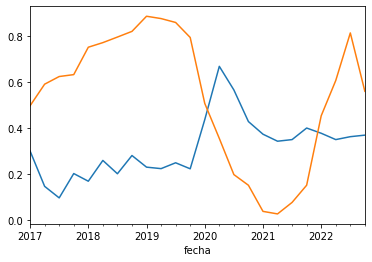

In [ ]:
for variable in df_outer.columns:
  resultado=seasonal_decompose(df_outer[variable], model='Additive', period=4)
  resultado.observed.plot()

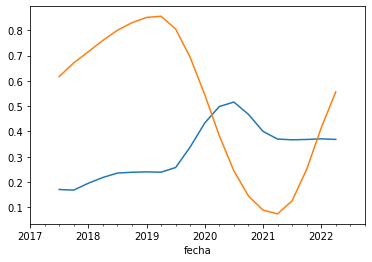

In [ ]:
for variable in df_outer.columns:
  resultado=seasonal_decompose(df_outer[variable], model='Additive', period=4)
  resultado.trend.plot()

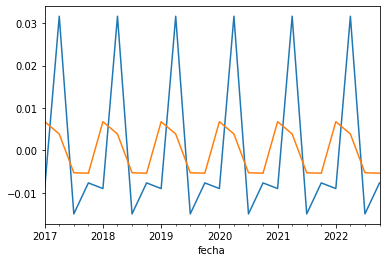

In [ ]:
for variable in df_outer.columns:
  resultado=seasonal_decompose(df_outer[variable], model='Additive', period=4)
  resultado.seasonal.plot()

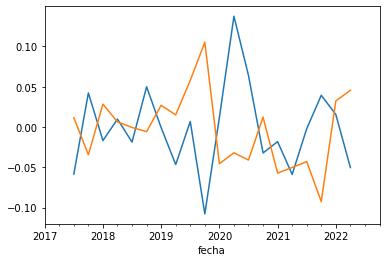

In [ ]:
for variable in df_outer.columns:
  resultado=seasonal_decompose(df_outer[variable], model='Additive', period=4)
  resultado.resid.plot()